### Importing Libraries

In [2]:
import io
import random
import string
import warnings
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer



# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity



# python imports
import re
import json
import os
from collections import Counter
import datetime as dt
from dateutil.parser import parse


# Visualization
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from wordcloud import WordCloud
from tqdm import tqdm_notebook
import geopandas


# twitter
# pip install twarc
from twarc import Twarc
import carmen
import pycountry as pc

resolver = carmen.get_resolver()
resolver.load_locations()


# Saving models
import pickle

import config

### Reading the Data

In [3]:
main_dir = '/home/vca_rishik/rishik/COVID-19-tweets/'
full_dir = main_dir + 'data_full/'
id_dir   = main_dir + 'data/'

popularity_list = []
text_list = []
entities_list = []

for file in sorted(os.listdir(full_dir))[:-2]:
    print('reading... ' + file)
    
    df_full = pd.read_csv(full_dir + file)

    text_list.append(df_full[['id', 'full_text', 'retweet_count', 'entities']])
#     popularity_list.append(df_full[['id', 'retweet_count', 'favorite_count']])
    entities_list.append(df_full[['id', 'entities', 'retweet_count']])
    
    print(file + ' ..done')
    print()

reading... 05-01-2020_full.csv
05-01-2020_full.csv ..done

reading... 05-02-2020_full.csv
05-02-2020_full.csv ..done

reading... 05-03-2020_full.csv
05-03-2020_full.csv ..done

reading... 05-04-2020_full.csv
05-04-2020_full.csv ..done

reading... 05-05-2020_full.csv
05-05-2020_full.csv ..done

reading... 05-06-2020_full.csv
05-06-2020_full.csv ..done

reading... 05-07-2020_full.csv
05-07-2020_full.csv ..done

reading... 05-08-2020_full.csv
05-08-2020_full.csv ..done

reading... 05-09-2020_full.csv
05-09-2020_full.csv ..done

reading... 05-10-2020_full.csv
05-10-2020_full.csv ..done

reading... 05-11-2020_full.csv
05-11-2020_full.csv ..done

reading... 05-12-2020_full.csv
05-12-2020_full.csv ..done

reading... 05-13-2020_full.csv
05-13-2020_full.csv ..done

reading... 05-14-2020_full.csv
05-14-2020_full.csv ..done

reading... 05-15-2020_full.csv
05-15-2020_full.csv ..done

reading... 05-16-2020_full.csv
05-16-2020_full.csv ..done

reading... 05-17-2020_full.csv
05-17-2020_full.csv ..don

## Analysing hashtags

#### Concatenating all days data and dropping duplicates as there might be overlaps in the tweets from two consecutive days

In [4]:
df_entities = pd.concat(entities_list)
df_entities = df_entities.drop_duplicates().reset_index(drop = True)

# df_entities = df_entities[:100000]

df_entities.tail()

,id,entities,retweet_count
3243562,1.263620e+18,"{'hashtags': [{'text': 'covid19', 'indices': [...",1.0
3243563,1.263620e+18,"{'hashtags': [{'text': '11thHour', 'indices': ...",15.0
3243564,1.263620e+18,"{'hashtags': [{'text': 'COVID19', 'indices': [...",0.0
3243565,1.263620e+18,"{'hashtags': [{'text': 'covid19', 'indices': [...",5.0
3243566,1.263620e+18,"{'hashtags': [{'text': 'eghi', 'indices': [41,...",2.0


#### Function to extract the hashtags from the entities excluding the ones used in the extraction of the tweets

In [5]:
query_hashtags = ["coronavirus", "coronavirusoutbreak", "coronaviruspandemic", "covid19", "covid_19", "epitwitter", "ihavecorona", "pandemic"]
def getHashtags(entity):
    if(isinstance(entity, str)):
        parsed = eval(entity)
        list_tags = [tag.get('text') for tag in parsed.get('hashtags') if tag.get('text').lower() not in query_hashtags]
        return list_tags
    
    return []

#### Adding a column to the dataframe conatining the hashtags from the tweet

In [6]:
df_entities['hashtags'] = df_entities.entities.apply(getHashtags)
df_entities.tail()


,id,entities,retweet_count,hashtags
3243562,1.263620e+18,"{'hashtags': [{'text': 'covid19', 'indices': [...",1.0,[]
3243563,1.263620e+18,"{'hashtags': [{'text': '11thHour', 'indices': ...",15.0,[11thHour]
3243564,1.263620e+18,"{'hashtags': [{'text': 'COVID19', 'indices': [...",0.0,[Memphis]
3243565,1.263620e+18,"{'hashtags': [{'text': 'covid19', 'indices': [...",5.0,[]
3243566,1.263620e+18,"{'hashtags': [{'text': 'eghi', 'indices': [41,...",2.0,"[eghi, WeAreGoingtoBeOK, diversebooks]"


#### Multipying the hashtag list for each tweet by its retweet count

function to multiply the hashtags

In [7]:
def multiplyHashtags(row):
    f = 0
    if(np.isnan(row.retweet_count)):
        f = 1
    else:
        f = int(row.retweet_count + 1)

    return row.hashtags*f
    

In [8]:
multiplied_hashtags = df_entities.apply(multiplyHashtags, axis = 1)
multiplied_hashtags.tail()

3243562                                                   []
3243563    [11thHour, 11thHour, 11thHour, 11thHour, 11thH...
3243564                                            [Memphis]
3243565                                                   []
3243566    [eghi, WeAreGoingtoBeOK, diversebooks, eghi, W...
dtype: object

#### Flattening the hashtags column

In [9]:
hashtags_list = [hashtag for hashtags in multiplied_hashtags for hashtag in hashtags]
hashtags_series = pd.Series(hashtags_list)
hashtags_series[:10]
# hashtags_list[:10]

0               SequoiaHR
1                      HR
2                Business
3                    ncdc
4         keepseniorssafe
5             Bracebridge
6                   China
7                   China
8    QuarantineLifeBeLike
9                     Job
dtype: object

In [10]:
counts = hashtags_series.value_counts()
counts.sort_index()
counts.head()

# counts = Counter(hashtags_list).most_common()
# counts_df = pd.DataFrame.from_dict(counts)
# counts_df.head()

lockdown    263382
COVIDー19    175851
China       170342
StayHome    170149
COVID       130802
dtype: int64

#### Plotting the frequency vs the number of appearances graph

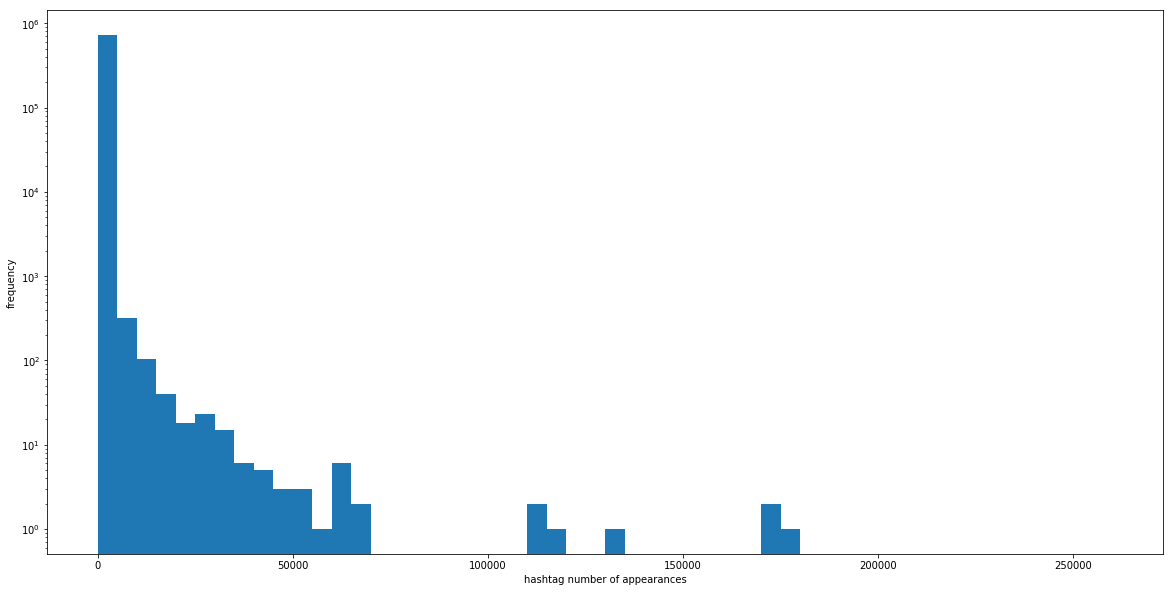

In [32]:
my_bins = np.arange(0, counts.max(), 5000)

# plot histogram of tweet counts
plt.figure(figsize=(20,10))
plt.hist(counts, bins = my_bins)
plt.xlabels = np.arange(1, counts.max(), 5)
plt.xlabel('hashtag number of appearances')
plt.ylabel('frequency')
plt.yscale('log', nonposy='clip')
plt.show()

### Getting the hashtags which appear a specific minimum number of times

In [12]:
popular_hashtags = counts.reset_index()
popular_hashtags.columns = ['hashtag', 'counts']
# popular_hashtags.dtypes

min_appearance = 20000
# find popular hashtags - make into python set for efficiency
popular_hashtags_set = set(popular_hashtags[popular_hashtags.counts.apply(lambda x: x > min_appearance)]['hashtag'])

print("Length of the popular hashtags set: ", len(popular_hashtags_set))
print()
print(popular_hashtags_set)

Length of the popular hashtags set:  90

{'China', 'WHO', 'InThisTogether', 'coronavirusuk', 'Pakistan', 'CoronaVirusUpdates', 'lockdown', 'SARSCoV2', 'HongKong', 'WhiteHouse', 'COVIDー19', 'Trump2020', 'mentalhealth', 'COVID__19', 'PPE', 'KAG', 'hydroxychloroquine', 'Covid19UK', 'CoronaVirusUpdate', 'StayHome', 'Odisha', 'HealthForAll', 'BorisJohnson', 'CoronaOutbreak', 'WHA73', 'Africa', 'BREAKING', 'staysafe', 'quarantine', 'COVID', 'Hydroxychloroquine', 'TakeResponsibility', 'auspol', 'QAnon', 'Iran', 'Lockdown3', 'Trump', 'health', 'StaySafe', 'lockdownuk', 'IndiaFightsCorona', 'COVIDIOTS', 'MAGA', 'SocialDistancing', 'Lockdown4', 'Wuhan', 'KillerCuomo', 'onpoli', 'education', 'NHS', 'vaccine', 'InternationalNursesDay', 'AI', 'Marr', 'Covid', 'Florida', 'stayhome', 'StayHomeSaveLives', 'healthcare', 'corona', 'lockdownextension', 'India', 'MothersDay', 'txlege', 'US', 'covid', 'socialdistancing', 'KAG2020', 'COVIDIDIOTS', 'Quarantine', 'IndiaFightsCoronavirus', 'ObamaGate', 'econom

### Getting the popular hashtags for each tweet

In [13]:
# make a new column with only the popular hashtags
df_entities['popular_hashtags'] = df_entities.hashtags.apply(lambda hashtag_list: [hashtag for hashtag in hashtag_list if hashtag in popular_hashtags_set])
# drop rows without popular hashtag
popular_hashtags_list_df = df_entities.loc[df_entities.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]
popular_hashtags_list_df.head()

,id,entities,retweet_count,hashtags,popular_hashtags
4,1.256010e+18,"{'hashtags': [{'text': 'China', 'indices': [17...",1.0,[China],[China]
6,1.256010e+18,"{'hashtags': [{'text': 'QuarantineLifeBeLike',...",0.0,"[QuarantineLifeBeLike, Job, QuarantineLife, lo...","[Lockdown, USA, StayAtHome]"
9,1.256010e+18,"{'hashtags': [{'text': 'COVID19', 'indices': [...",1.0,"[Pakistan, terrorism]",[Pakistan]
10,1.256010e+18,"{'hashtags': [{'text': 'JayaBhattacharya', 'in...",0.0,"[JayaBhattacharya, KyunkiSaasBhiKabhiBahuThi, ...",[Lockdown]
32,1.256010e+18,"{'hashtags': [{'text': 'IndiaFightsCorona', 'i...",62.0,"[IndiaFightsCorona, StayAtHomeSaveLives, StayH...","[IndiaFightsCorona, StayHomeStaySafe, StayHome..."


### Plotting the correlation matrix for the popular hashtags

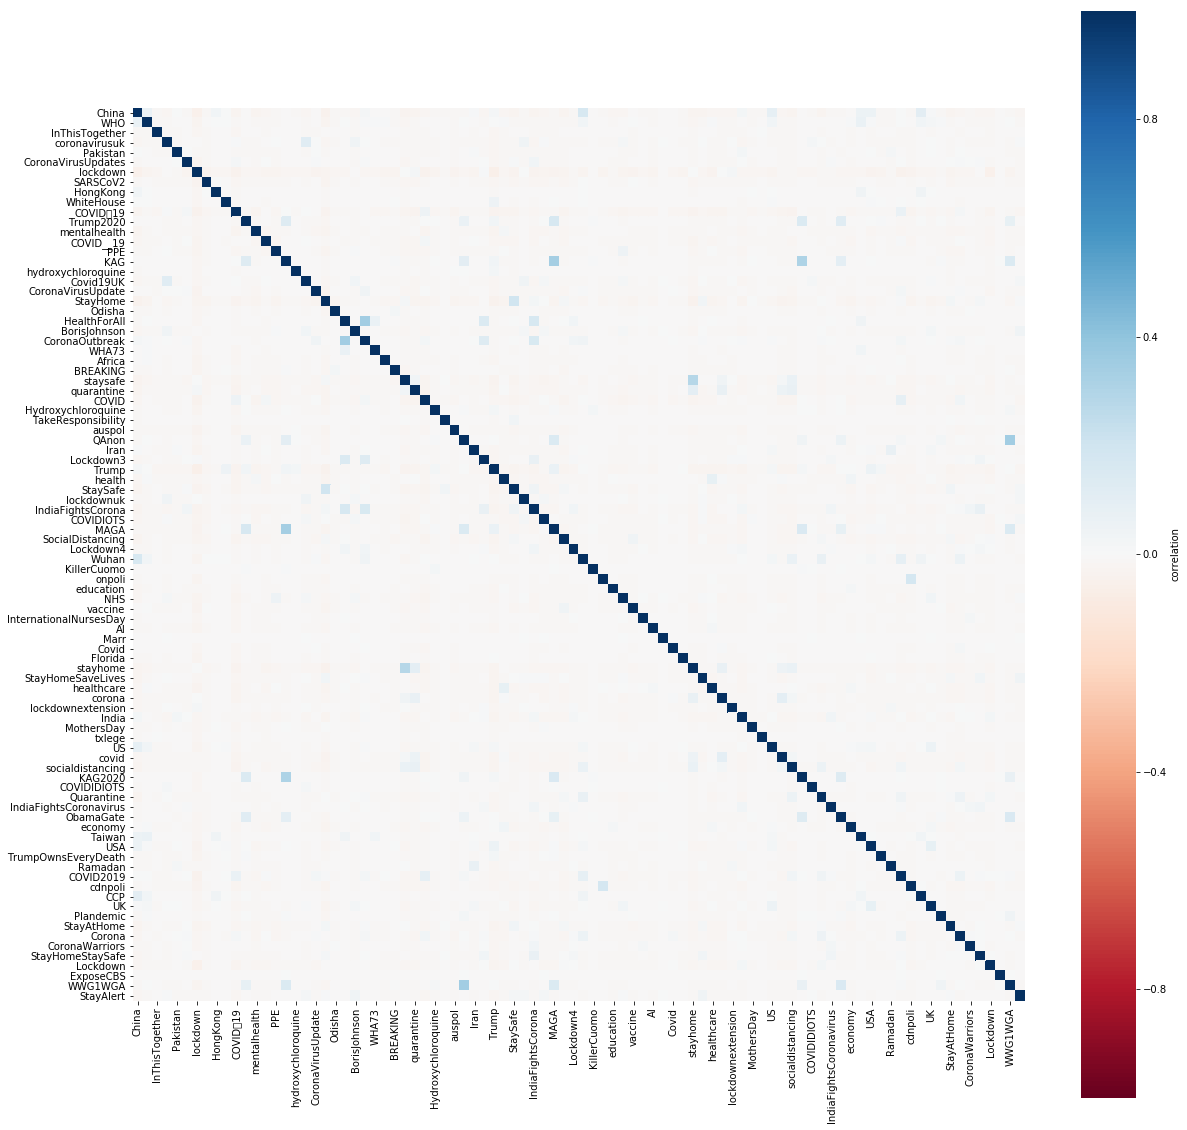

In [14]:
hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]

for hashtag in popular_hashtags_set:
    # make columns to encode presence of hashtags
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(lambda hashtag_list: int(hashtag in hashtag_list))
    
hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)

correlations = hashtag_matrix.corr()

# plot the correlation matrix
plt.figure(figsize=(20,20))
sns.heatmap(correlations,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True,
    cbar_kws={'label':'correlation'})
plt.savefig(main_dir + 'outputs/hashtags_correlation.png')
plt.show()


## Topic Modelling

#### Concatenating all days data and dropping duplicates as there might be overlaps in the tweets from two consecutive days

In [15]:
df_text = pd.concat(text_list)
df_text = df_text.drop_duplicates().reset_index(drop = True)

# df_text = df_text[:100000]

df_text.tail()

,id,full_text,retweet_count,entities
3243562,1.263620e+18,Not downplaying #covid19 but what about the dr...,1.0,"{'hashtags': [{'text': 'covid19', 'indices': [..."
3243563,1.263620e+18,"Surrounded by Ford executives wearing masks, t...",15.0,"{'hashtags': [{'text': '11thHour', 'indices': ..."
3243564,1.263620e+18,@secretXmedia @DocJackGriffin @MayorMemphis Cu...,0.0,"{'hashtags': [{'text': 'COVID19', 'indices': [..."
3243565,1.263620e+18,Encouraging the state and @acluct to negotiate...,5.0,"{'hashtags': [{'text': 'covid19', 'indices': [..."
3243566,1.263620e+18,Digital story time in my niece’s class 🥰 #eghi...,2.0,"{'hashtags': [{'text': 'eghi', 'indices': [41,..."


### Cleaning the tweet text

Submodules for cleaning the text

In [16]:
def checkEntity(x):
    try :  
        float(x)
#         print("entity: ", x)
        return True
    except : 
        return False
    
def get_text_cleaned(tweet, stem = False):
    text = tweet['full_text']
    if(checkEntity(tweet['entities'])):
        return text
    
    entities = eval(tweet['entities'])

    slices = []
    #Strip out the urls.
    if 'urls' in entities:
        for url in entities['urls']:
            slices += [{'start': url['indices'][0], 'stop': url['indices'][1]}]
    
    #Strip out the hashtags.
    if 'hashtags' in entities:
        for tag in entities['hashtags']:
            slices += [{'start': tag['indices'][0], 'stop': tag['indices'][1]}]
    
    #Strip out the user mentions.
    if 'user_mentions' in entities:
        for men in entities['user_mentions']:
            slices += [{'start': men['indices'][0], 'stop': men['indices'][1]}]
    
    #Strip out the media.
    if 'media' in entities:
        for med in entities['media']:
            slices += [{'start': med['indices'][0], 'stop': med['indices'][1]}]
    
    #Strip out the symbols.
    if 'symbols' in entities:
        for sym in entities['symbols']:
            slices += [{'start': sym['indices'][0], 'stop': sym['indices'][1]}]
    
    # Sort the slices from highest start to lowest.
    slices = sorted(slices, key=lambda x: -x['start'])
    
    #No offsets, since we're sorted from highest to lowest.
    for s in slices:
        text = text[:s['start']] + text[s['stop']:]
    # Remove numbers
    text = re.sub('([0-9]+)', '', text)
    
    # Remove punctuations
    punctuations = '#!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'
    text = re.sub('['+ punctuations + ']+', ' ', text)
    
    return text.lower()

def multiplyWithRetweetCount(text, retweet_count):
    f = 0
    if(np.isnan(retweet_count)):
        f = 1
    else:
        f = int(retweet_count + 1)

    return text*f
    

def get_text_normalized(tweet):
    #Sanitize the text first.
    text = get_text_cleaned(tweet).split()
    
    stop_words = set(stopwords.words('english'))
    stop_words.update(['coronavirusoutbreak', 'coronavirusPandemic', 'covid_19', 'epitwitter', 'ihavecorona', 'amp', 'coronavirus', 'covid19', 'covid-19'])
    
    #Remove the stop words.
    text = [t for t in text if t not in stop_words]
    text = multiplyWithRetweetCount(text, tweet.retweet_count)
    
    #Create the stemmer.
#     stemmer = LancasterStemmer()
    stemmer = SnowballStemmer('english')
    
    #Stem the words.
#     return ' '.join([stemmer.stem(t) for t in text])
    return ' '.join(text)

#### Adding a column for the cleaned text

In [17]:
df_text['cleaned_text'] = df_text.apply(get_text_normalized, axis = 1)
df_text.head()

,id,full_text,retweet_count,entities,cleaned_text
0,1.256010e+18,"As a response to COVID19, 30% of companies sur...",0.0,"{'hashtags': [{'text': 'SequoiaHR', 'indices':...",response covid companies surveyed offering hom...
1,1.256010e+18,@NCDCgov Covid-19 Positive results coming from...,0.0,"{'hashtags': [{'text': 'COVID19', 'indices': [...",covid positive results coming kano alarming fr...
2,1.256010e+18,#keepseniorssafe Despite a severe uptick in pr...,0.0,"{'hashtags': [{'text': 'keepseniorssafe', 'ind...",despite severe uptick protocols procedures bey...
3,1.256010e+18,Maharashtra has reached the grim milestone of ...,8.0,"{'hashtags': [{'text': 'coronavirus', 'indices...",maharashtra reached grim milestone plus cases ...
4,1.256010e+18,"People may blame #China for #COVID19, but many...",1.0,"{'hashtags': [{'text': 'China', 'indices': [17...",people may blame many chinese citizens actuall...


#### Vectorize the text of the tweets

In [18]:
# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=0.01, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(df_text['cleaned_text']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()
tf_feature_names[:10]

['across',
 'also',
 'another',
 'around',
 'back',
 'best',
 'better',
 'business',
 'businesses',
 'call']

#### Function to display the topics given a model

In [19]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

### Applying Negative Matix Factorization

In [20]:
n_topics = 10
# model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model = NMF(n_components=n_topics, random_state=0, alpha=.1, l1_ratio=.5)
model.fit(tf)
no_top_words = 10
topics_df = display_topics(model, tf_feature_names, no_top_words)
topics_df.to_csv(main_dir + '/outputs/NMF_topics.csv')
topics_df

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,death,200.1,patients,196.6,like,148.6,get,191.2,deaths,151.9,’s,195.8,”,249.0,i,116.2,country,164.5,let,154.8
1,covid,192.4,health,100.9,people,83.9,i,189.2,people,122.5,it,78.1,workers,94.7,public,100.6,one,99.3,without,150.8
2,still,96.5,going,98.0,back,83.1,time,182.0,tested,103.9,state,33.8,fight,22.0,may,99.6,workers,83.0,like,147.3
3,even,96.5,testing,94.7,death,79.2,test,167.3,never,96.6,trump,33.6,trump,19.7,good,98.8,due,72.2,mask,14.4
4,video,95.8,made,89.4,total,77.8,via,163.5,death,96.1,one,22.6,’t,16.7,also,93.3,information,68.8,’t,7.6
5,time,95.2,like,83.8,life,77.4,back,24.5,virus,95.6,number,22.3,don,13.6,continue,10.6,find,68.6,says,6.0
6,make,95.1,”,64.4,case,74.2,social,15.7,covid,86.7,first,22.2,distancing,13.5,end,10.5,covid,67.4,good,2.9
7,please,95.0,risk,8.1,’s,62.2,end,12.8,”,35.5,want,21.9,social,13.4,social,10.4,see,11.8,would,2.3
8,it,95.0,world,6.3,uk,3.8,continue,12.4,cases,25.4,’t,20.1,next,13.2,back,9.5,pandemic,10.5,come,2.3
9,think,94.0,thanks,6.2,care,3.7,still,11.6,number,23.6,good,19.8,face,12.5,still,9.2,world,9.9,virus,1.9


### Applying LDA

In [21]:
n_topics = 10
model = LatentDirichletAllocation(n_components=n_topics, random_state=0)
# model = NMF(n_components=n_topics, random_state=0, alpha=.1, l1_ratio=.5)
model.fit(tf)
no_top_words = 10
topics_df = display_topics(model, tf_feature_names, no_top_words)
topics_df.to_csv(main_dir + 'outputs/LDA_topics.csv')
topics_df

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,get,616434.3,pandemic,1143030.7,’s,1785872.3,”,776789.1,help,658673.1,cases,1528623.9,covid,959424.5,us,1043578.4,people,1625214.8,today,758254.7
1,workers,543368.6,one,743174.3,health,1036606.8,like,694133.6,need,608393.9,new,1435586.2,state,548159.7,trump,630929.7,’t,641786.4,due,409323.5
2,must,425253.5,patients,560179.2,world,487670.7,would,441119.3,crisis,570748.3,deaths,1076603.5,virus,523831.6,death,535100.2,time,610159.0,see,402141.6
3,care,408623.3,positive,396007.5,day,468401.9,says,425159.4,support,502577.4,total,573942.1,testing,519972.0,uk,410551.3,home,535251.0,know,386179.3
4,also,354445.0,tested,393373.1,public,456335.2,country,413091.0,response,465139.9,may,455175.0,first,429725.9,please,377881.0,government,514580.6,pm,370390.9
5,test,321909.0,india,352518.2,it,421967.4,let,363229.2,fight,429651.4,number,450644.0,states,315727.2,news,319284.0,lockdown,500304.1,social,354846.0
6,spread,312541.0,week,271678.5,keep,303423.8,even,318622.3,china,360567.0,confirmed,296307.1,million,314368.1,via,315388.2,work,479610.0,still,333129.9
7,thank,311191.5,take,243464.4,every,279341.6,president,315940.8,watch,318957.8,reported,277616.1,face,266253.3,great,258770.6,back,458983.8,risk,302773.4
8,make,297612.0,important,211122.6,working,226819.0,dr,310342.6,global,307893.2,case,224790.5,masks,261100.6,read,255263.8,many,446882.2,life,293292.5
9,way,294835.8,last,201341.1,safe,208625.6,said,303896.2,medical,303762.9,today,205787.0,vaccine,248888.0,much,241458.8,go,362416.7,year,259560.5


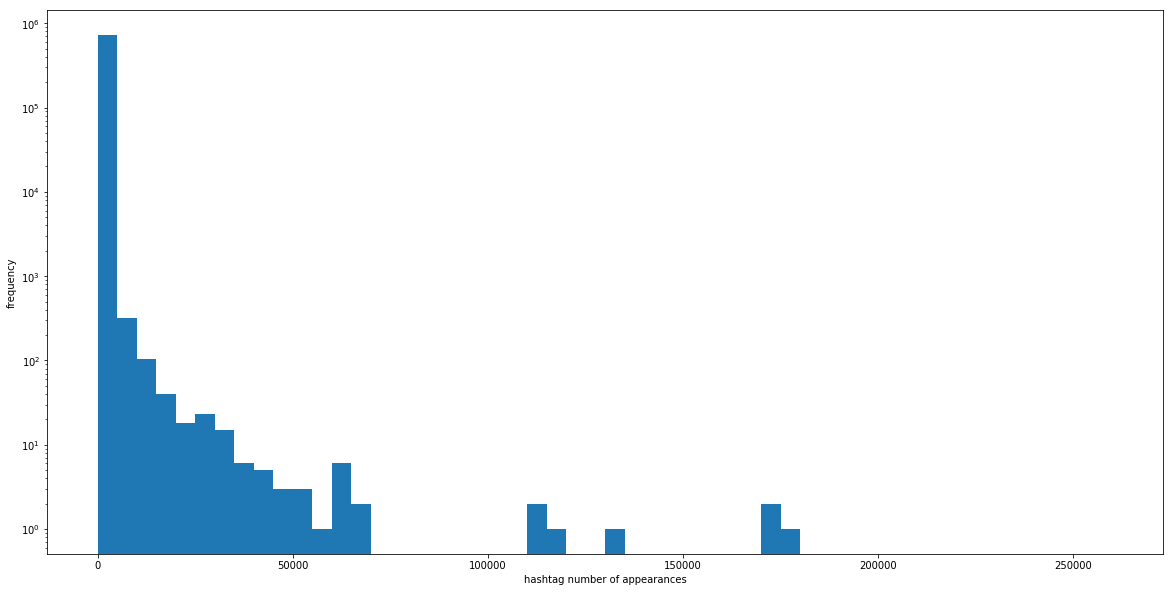

In [31]:
my_bins = np.arange(0,counts.max(), 5000)

# plot histogram of tweet counts
plt.figure(figsize=(20,10))
plt.hist(counts, bins = my_bins)
plt.xlabels = np.arange(1,counts.max()+1, 5)
plt.xlabel('hashtag number of appearances')
plt.ylabel('frequency')
plt.yscale('log', nonposy='clip')
plt.show()

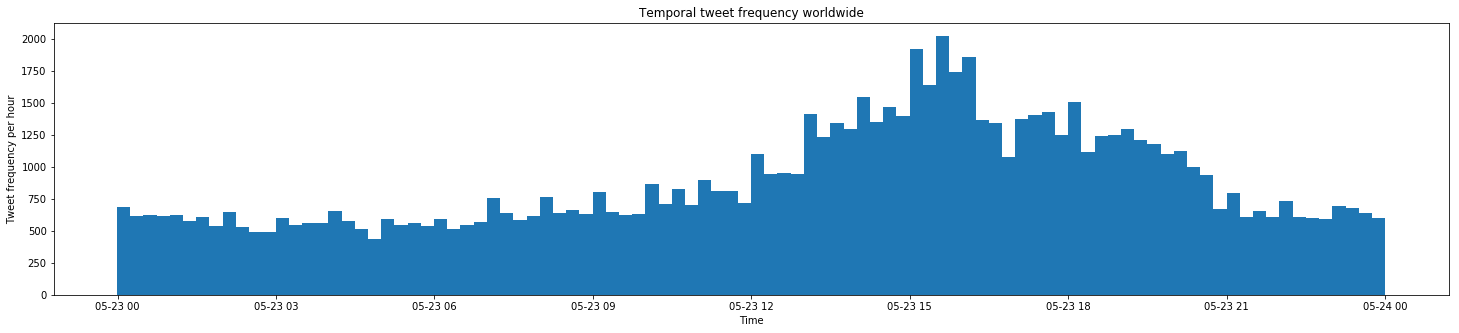

In [35]:
a = pd.read_csv(full_dir + '05-23-2020_full.csv')
fig = plt.figure(figsize=(25,5))
ax = fig.add_subplot(111)
ax.set(title='Temporal tweet frequency worldwide', xlabel='Time', ylabel='Tweet frequency per hour')
plt.hist(pd.to_datetime(a.created_at), bins = 24*4)
plt.show()